Processing team: CIN


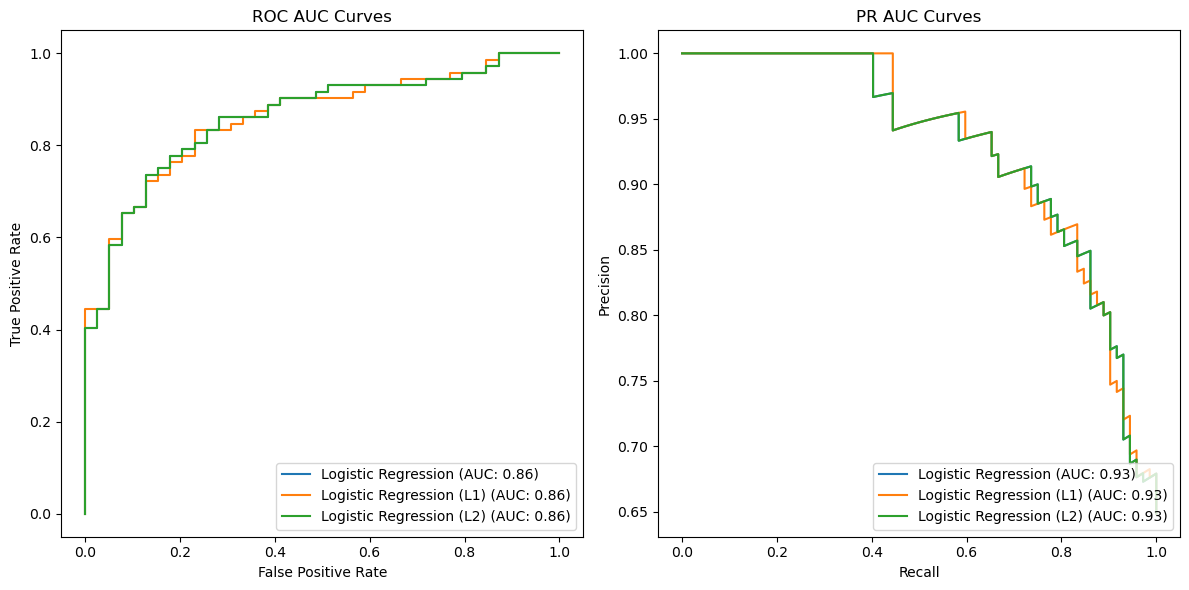

Metrics Results for CIN:
Logistic Regression: {'accuracy': 0.7927927927927928, 'precision': 0.8266666666666667, 'recall': 0.8611111111111112, 'f1_score': 0.8435374149659864, 'roc_auc': 0.8607549857549858, 'pr_auc': 0.9270692818013899}
Logistic Regression (L1): {'accuracy': 0.7927927927927928, 'precision': 0.8266666666666667, 'recall': 0.8611111111111112, 'f1_score': 0.8435374149659864, 'roc_auc': 0.8600427350427351, 'pr_auc': 0.9275695157336474}
Logistic Regression (L2): {'accuracy': 0.7927927927927928, 'precision': 0.8266666666666667, 'recall': 0.8611111111111112, 'f1_score': 0.8435374149659864, 'roc_auc': 0.8607549857549858, 'pr_auc': 0.9270692818013899}
Processing team: PHI


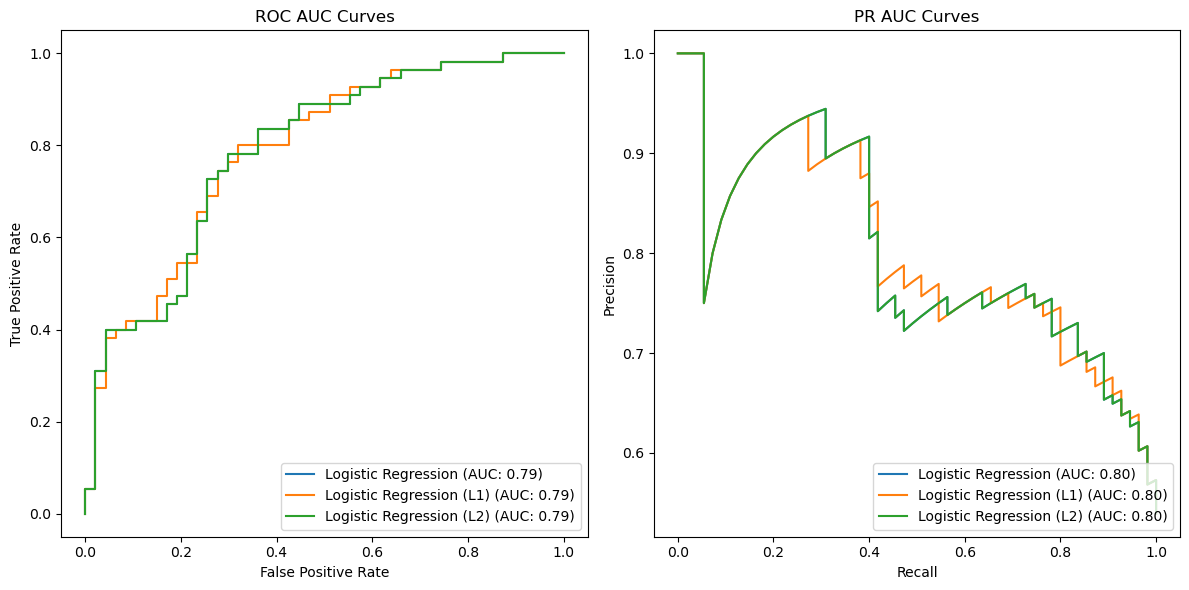

Metrics Results for PHI:
Logistic Regression: {'accuracy': 0.7352941176470589, 'precision': 0.7258064516129032, 'recall': 0.8181818181818182, 'f1_score': 0.7692307692307693, 'roc_auc': 0.7868471953578337, 'pr_auc': 0.7969932556587326}
Logistic Regression (L1): {'accuracy': 0.7058823529411765, 'precision': 0.6984126984126984, 'recall': 0.8, 'f1_score': 0.7457627118644068, 'roc_auc': 0.7872340425531915, 'pr_auc': 0.7972365896435987}
Logistic Regression (L2): {'accuracy': 0.7352941176470589, 'precision': 0.7258064516129032, 'recall': 0.8181818181818182, 'f1_score': 0.7692307692307693, 'roc_auc': 0.7868471953578337, 'pr_auc': 0.7969932556587326}
Processing team: KC


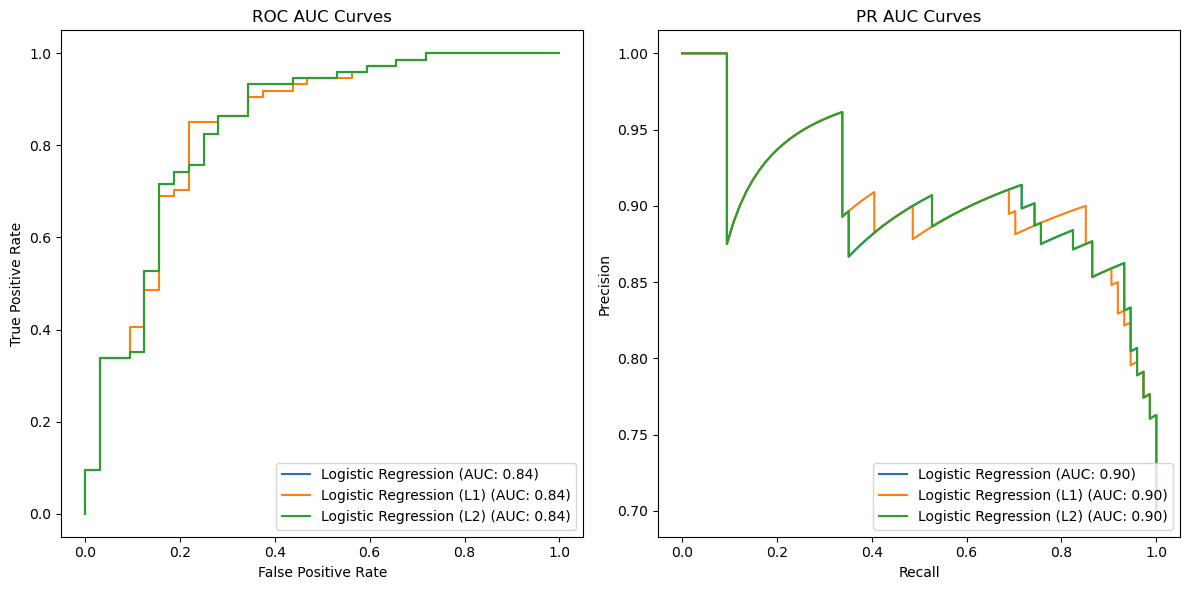

Metrics Results for KC:
Logistic Regression: {'accuracy': 0.7830188679245284, 'precision': 0.7741935483870968, 'recall': 0.972972972972973, 'f1_score': 0.8622754491017964, 'roc_auc': 0.8403716216216216, 'pr_auc': 0.9034725288965556}
Logistic Regression (L1): {'accuracy': 0.7830188679245284, 'precision': 0.7741935483870968, 'recall': 0.972972972972973, 'f1_score': 0.8622754491017964, 'roc_auc': 0.8399493243243243, 'pr_auc': 0.903876126075833}
Logistic Regression (L2): {'accuracy': 0.7830188679245284, 'precision': 0.7741935483870968, 'recall': 0.972972972972973, 'f1_score': 0.8622754491017964, 'roc_auc': 0.8403716216216216, 'pr_auc': 0.9034725288965556}
Processing team: SF


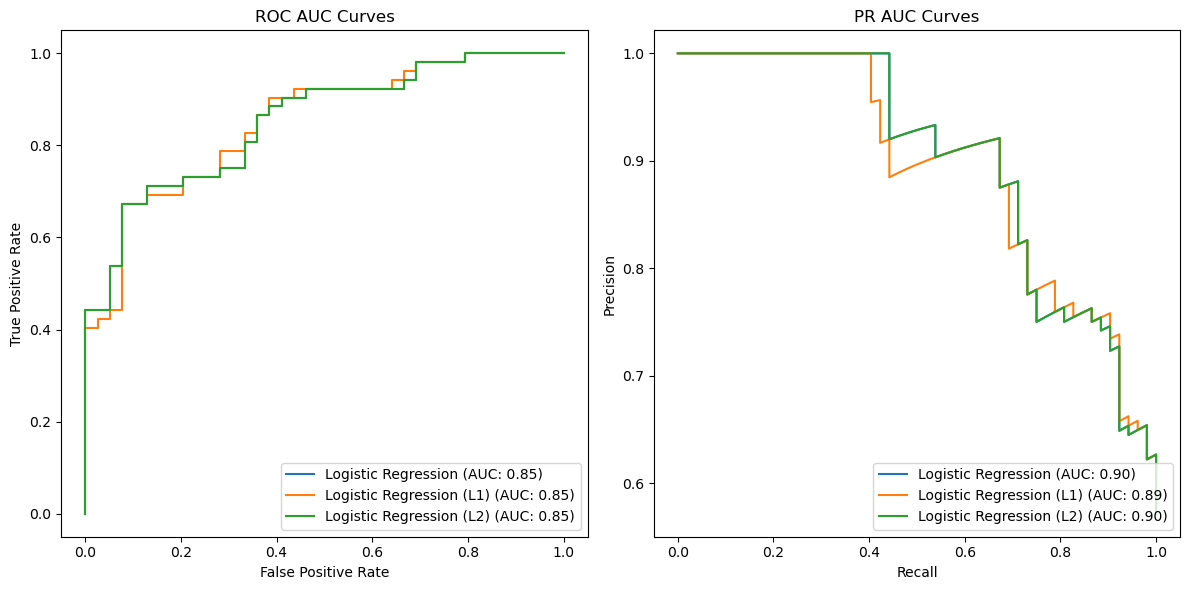

Metrics Results for SF:
Logistic Regression: {'accuracy': 0.7692307692307693, 'precision': 0.7627118644067796, 'recall': 0.8653846153846154, 'f1_score': 0.8108108108108109, 'roc_auc': 0.8515779092702169, 'pr_auc': 0.8984144733229279}
Logistic Regression (L1): {'accuracy': 0.7582417582417582, 'precision': 0.75, 'recall': 0.8653846153846154, 'f1_score': 0.8035714285714286, 'roc_auc': 0.8505917159763314, 'pr_auc': 0.8938958525355333}
Logistic Regression (L2): {'accuracy': 0.7692307692307693, 'precision': 0.7627118644067796, 'recall': 0.8653846153846154, 'f1_score': 0.8108108108108109, 'roc_auc': 0.8515779092702169, 'pr_auc': 0.8984144733229279}


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, precision_recall_curve, roc_curve, auc
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load data
plays = pd.read_csv('plays.csv')

# Team-specific data
teams = ['CIN', 'PHI', 'KC', 'SF']
for team in teams:
    print(f"Processing team: {team}")
    team_plays = plays[plays['possessionTeam'] == team].copy()
    team_plays['scoreDifferential'] = team_plays['preSnapHomeScore'] - team_plays['preSnapVisitorScore']
    team_plays['isLeading'] = (team_plays['scoreDifferential'] > 0).astype(int)
    team_plays['isRedZone'] = (team_plays['absoluteYardlineNumber'] <= 20).astype(int)
    team_plays['shortYardage'] = (team_plays['yardsToGo'] <= 2).astype(int)
    team_plays['thirdAndLong'] = ((team_plays['down'] == 3) & (team_plays['yardsToGo'] > 7)).astype(int)
    team_plays['fourthQuarter'] = (team_plays['quarter'] == 4).astype(int)
    team_plays['twoMinuteDrill'] = ((team_plays['quarter'] >= 2) & 
                                    (team_plays['gameClock'].str.split(':').str[0].astype(int) <= 2))
    team_plays['playType'] = team_plays['passResult'].apply(lambda x: 0 if pd.isnull(x) else 1)

    features = [
        'yardsToGo', 'quarter', 'down', 'expectedPoints', 'scoreDifferential', 'isLeading',
        'isRedZone', 'shortYardage', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill',
        'preSnapHomeScore', 'preSnapVisitorScore', 'offenseFormation'
    ]
    data = team_plays[features + ['playType']]
    encoder = OneHotEncoder(sparse_output=False)
    encoded_formations = encoder.fit_transform(data[['offenseFormation']])
    formation_columns = [f'formation_{cat}' for cat in encoder.categories_[0]]
    encoded_df = pd.DataFrame(encoded_formations, columns=formation_columns)
    data = pd.concat([data.reset_index(drop=True), encoded_df], axis=1).drop(columns=['offenseFormation'])
    X = data.drop(columns=['playType'])
    y = data['playType']
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=28, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=28, stratify=y_train_full)
    
    # Standardizing for some models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500, random_state=28),
        "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, random_state=28),
        "Logistic Regression (L2)": LogisticRegression(penalty='l2', max_iter=500, random_state=28),
    }
    
    # Storage for metrics
    metrics_results = {model_name: {} for model_name in models.keys()}
    
    # Initialize plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("ROC AUC Curves")
    plt.subplot(1, 2, 2)
    plt.title("PR AUC Curves")
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        metrics_results[model_name]['accuracy'] = accuracy_score(y_test, y_pred)
        metrics_results[model_name]['precision'] = precision_score(y_test, y_pred)
        metrics_results[model_name]['recall'] = recall_score(y_test, y_pred)
        metrics_results[model_name]['f1_score'] = f1_score(y_test, y_pred)
        metrics_results[model_name]['roc_auc'] = roc_auc_score(y_test, y_pred_prob)
        
        # ROC AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC: {metrics_results[model_name]['roc_auc']:.2f})")
        
        # PR AUC
        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        pr_auc = auc(recall, precision)
        metrics_results[model_name]['pr_auc'] = pr_auc
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f"{model_name} (AUC: {pr_auc:.2f})")
    
    # ROC curve plot formatting
    plt.subplot(1, 2, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    
    # PR curve plot formatting
    plt.subplot(1, 2, 2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # Display results
    print(f"Metrics Results for {team}:")
    for model_name, metrics in metrics_results.items():
        print(f"{model_name}: {metrics}")
